In [69]:
from preprocessing_utils import preprocess_data, preprocess_validation_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

### Preprocessing 

In [70]:
# Reading in the training/test data
file_path = '../data/project_adult.csv'

try:
    df = pd.read_csv(file_path, header=None, encoding='utf-8')
    print(f"Successfully loaded '{file_path}'. First 5 rows:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty or contains no data.")
except pd.errors.ParserError as e:
    print(f"Error: A parsing error occurred while reading '{file_path}': {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# preprocess training data
X, y = preprocess_data(df)

Successfully loaded '../data/project_adult.csv'. First 5 rows:
        0    1                 2       3          4              5   \
0      NaN  age         workclass  fnlwgt  education  education-num   
1   5514.0   33         Local-gov  198183  Bachelors             13   
2  19777.0   36           Private   86459  Assoc-voc             11   
3  10781.0   58  Self-emp-not-inc  203039        9th              5   
4  32240.0   21           Private  180190  Assoc-voc             11   

                   6                7              8      9       10  \
0      marital-status       occupation   relationship   race     sex   
1       Never-married   Prof-specialty  Not-in-family  White  Female   
2  Married-civ-spouse  Exec-managerial        Husband  White    Male   
3           Separated     Craft-repair  Not-in-family  White    Male   
4  Married-civ-spouse  Farming-fishing        Husband  White    Male   

             11            12              13              14      15  
0  ca

,original_index,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Missing,...,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,sex_Female,sex_Male,class
0,1,-0.408756,0.080051,1.133702,-0.145715,-0.217998,0.779460,0,1,0,...,0,0,0,0,1,0,0,1,0,1
1,2,-0.188857,-0.981653,0.357049,-0.145715,4.457168,0.779460,0,0,0,...,0,0,0,0,1,0,0,0,1,1
2,3,1.423734,0.126197,-1.972910,-0.145715,-0.217998,-0.031510,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,4,-1.288351,-0.090935,0.357049,-0.145715,-0.217998,0.455072,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,5,-0.848554,0.856334,-0.031277,-0.145715,-0.217998,-0.031510,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [71]:
# Reading in the validation data

file_path = '../data/project_validation_inputs.csv'

try:
    df_test = pd.read_csv(file_path, header=None, encoding='utf-8')
    print(f"Successfully loaded '{file_path}'. First 5 rows:")
    print(df_test.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty or contains no data.")
except pd.errors.ParserError as e:
    print(f"Error: A parsing error occurred while reading '{file_path}': {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# preprocess test data
X_df_test = preprocess_validation_data(df_test)

Successfully loaded '../data/project_validation_inputs.csv'. First 5 rows:
        0    1          2       3             4              5   \
0      NaN  age  workclass  fnlwgt     education  education-num   
1  14160.0   27    Private  160178  Some-college             10   
2  27048.0   45  State-gov   50567       HS-grad              9   
3  28868.0   29    Private  185908     Bachelors             13   
4   5667.0   30    Private  190040     Bachelors             13   

                   6                  7              8      9       10  \
0      marital-status         occupation   relationship   race     sex   
1            Divorced       Adm-clerical  Not-in-family  White  Female   
2  Married-civ-spouse    Exec-managerial           Wife  White  Female   
3  Married-civ-spouse    Exec-managerial        Husband  Black    Male   
4       Never-married  Machine-op-inspct  Not-in-family  White  Female   

             11            12              13              14  
0  capital-ga

,original_index,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Missing,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,sex_Female,sex_Male
0,1,-0.851191,-0.277853,-0.031693,-0.147225,-0.211274,-0.212164,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,2,0.469374,-1.304090,-0.421896,-0.147225,-0.211274,-0.051009,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,3,-0.704461,-0.036955,1.138915,-0.147225,-0.211274,1.157652,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,4,-0.631097,0.001731,1.138915,-0.147225,-0.211274,-0.051009,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,5,-0.704461,-0.004766,-0.031693,0.128973,-0.211274,0.754765,0,0,0,...,0,0,0,0,0,1,0,0,0,1


# 2. Implement the Perceptron and Adaline algorithms
- Train Perceptron and Adline models (at least AdalineSGD).
- Plot the number of misclassifications (Perceptron) and MSE (Adaline) over epochs.
- Find the accuracy of your best models from both algorithms
- Use best performing models to predict outputs for project_validation_inputs.
- Use provided code to implement scikit-learn’s Perceptron and Adaline algorithms. Find the accuracy on the validation data using your best models for both.

In [72]:
# split data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
# manual adaline and perceptron implementations

# adaline sgd
class AdalineSGD:
    """ADAptive Linear Neuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
      Mean squared error loss function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float64(0.)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)


class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # if you use libarry versions stated by book use float_, else if new use float64
        # self.b_ = np.float_(0.)
        self.b_ = np.float64(0.)
        
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

In [74]:
# assigning feature columns to variable for easy recall and avoid dropping 'original_index'
# also validation dataset lacked 3 columns after encoded so excluding those as well to avoid shape mismatch issues

feature_cols = [col for col in X_train.columns if col not in ['original_index', 'workclass_Never-worked', 'native-country_Holand-Netherlands', 'native-country_Outlying-US(Guam-USVI-etc)']]
print(feature_cols)

['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Missing', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay', 'education_10th', 'education_11th', 'education_12th', 'education_1st-4th', 'education_5th-6th', 'education_7th-8th', 'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate', 'education_HS-grad', 'education_Masters', 'education_Preschool', 'education_Prof-school', 'education_Some-college', 'marital-status_Divorced', 'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse', 'marital-status_Married-spouse-absent', 'marital-status_Never-married', 'marital-status_Separated', 'marital-status_Widowed', 'occupation_Adm-clerical', 'occupation_Armed-Forces', 'occupation_Craft-repair', 'occupation_Exec-managerial', 'occupation_Farming-fishing', 'occupation

Perceptron accuracy with n_iter 5 and eta 0.01: 0.8050
Perceptron accuracy with n_iter 5 and eta 0.001: 0.8035
Perceptron accuracy with n_iter 5 and eta 0.0001: 0.8152
Perceptron accuracy with n_iter 5 and eta 1e-05: 0.8163
Perceptron accuracy with n_iter 5 and eta 1e-06: 0.7441
Perceptron accuracy with n_iter 10 and eta 0.01: 0.7950
Perceptron accuracy with n_iter 10 and eta 0.001: 0.8015
Perceptron accuracy with n_iter 10 and eta 0.0001: 0.8084
Perceptron accuracy with n_iter 10 and eta 1e-05: 0.8092
Perceptron accuracy with n_iter 10 and eta 1e-06: 0.7835
Perceptron accuracy with n_iter 15 and eta 0.01: 0.8155
Perceptron accuracy with n_iter 15 and eta 0.001: 0.8146
Perceptron accuracy with n_iter 15 and eta 0.0001: 0.7975
Perceptron accuracy with n_iter 15 and eta 1e-05: 0.8182
Perceptron accuracy with n_iter 15 and eta 1e-06: 0.7964
Perceptron accuracy with n_iter 20 and eta 0.01: 0.8111
Perceptron accuracy with n_iter 20 and eta 0.001: 0.8190
Perceptron accuracy with n_iter 20 an

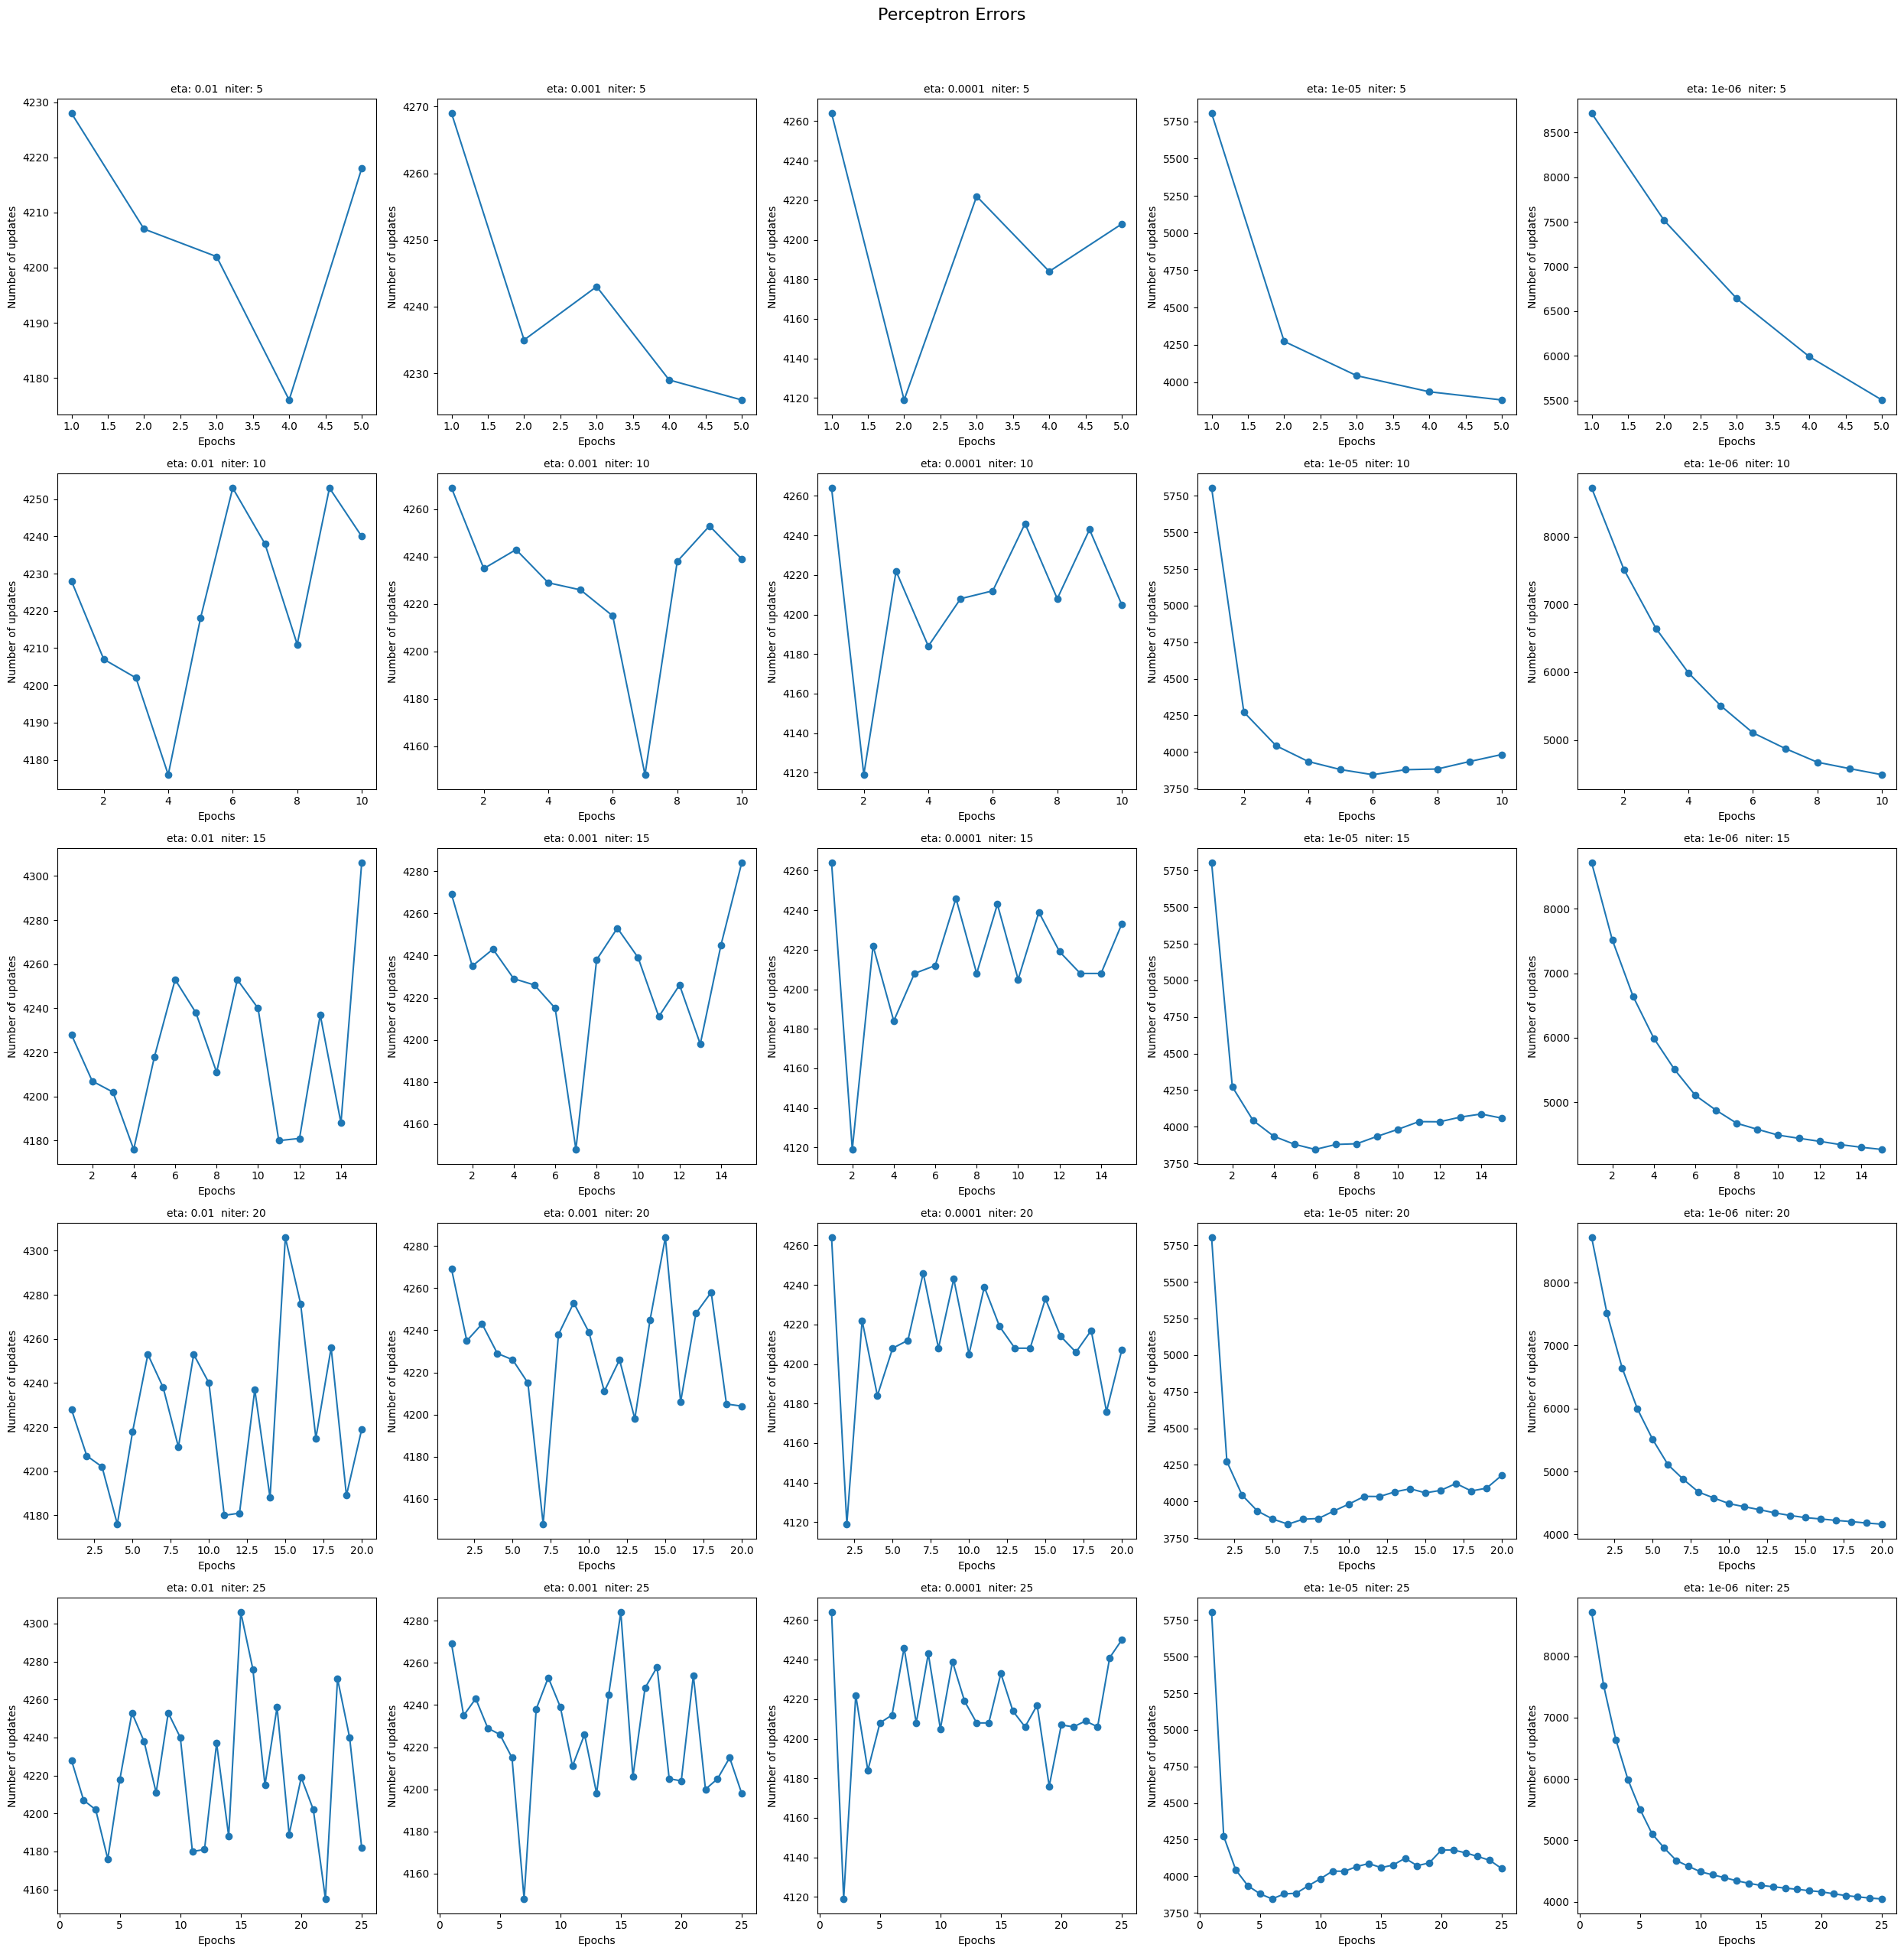


Highest accuracy: 0.8207 with eta 0.001 and n_iter 25


In [75]:
# perceptron
# code pulled from in class activities

# tuned hyperparameters
list_eta = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
list_niter = [5, 10, 15, 20, 25]

# Create a new figure for perceptron plots
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))
fig.suptitle("Perceptron Errors", fontsize=16, y=1.02)

# added this to assist in finding the best combo for highest accuracy
best_accuracy = 0
best_combo = (None, None)  # (eta, n_iter)

for j, n_temp in enumerate(list_niter):

    for i, e_temp in enumerate(list_eta):
        ppn = Perceptron(n_iter=n_temp, eta=e_temp).fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
        ax[j, i].plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Number of updates', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)
        
        # Also calculate and print accuracy
        y_pred = ppn.predict(X_test.loc[:,feature_cols].values)
        acc = accuracy_score(y_test.loc[:, 'class'].values, y_pred)      
        print(f"Perceptron accuracy with n_iter {n_temp} and eta {e_temp}: {acc:.4f}") 

        if acc > best_accuracy:            # update everytime there's a new highest accuracy
            best_accuracy = acc            
            best_combo = (e_temp, n_temp)
    
plt.tight_layout()
plt.show()

# print out highest accuracy combo
print(f"\nHighest accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and n_iter {best_combo[1]}")

Adaline accuracy with n_iter 5 and eta 0.01: 0.5188
Adaline accuracy with n_iter 5 and eta 0.001: 0.8424
Adaline accuracy with n_iter 5 and eta 0.0001: 0.8428
Adaline accuracy with n_iter 5 and eta 1e-05: 0.8344
Adaline accuracy with n_iter 5 and eta 1e-06: 0.7726


/var/folders/k7/4s5pb6rj0tn97yztvj3ty_kh0000gn/T/ipykernel_95038/4069530535.py:96: RuntimeWarning: overflow encountered in scalar power
  loss = error**2
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Adaline accuracy with n_iter 10 and eta 0.01: 0.6311
Adaline accuracy with n_iter 10 and eta 0.001: 0.8376
Adaline accuracy with n_iter 10 and eta 0.0001: 0.8430
Adaline accuracy with n_iter 10 and eta 1e-05: 0.8382
Adaline accuracy with n_iter 10 and eta 1e-06: 0.7758


/var/folders/k7/4s5pb6rj0tn97yztvj3ty_kh0000gn/T/ipykernel_95038/4069530535.py:96: RuntimeWarning: overflow encountered in scalar power
  loss = error**2
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Adaline accuracy with n_iter 15 and eta 0.01: 0.3344
Adaline accuracy with n_iter 15 and eta 0.001: 0.8420
Adaline accuracy with n_iter 15 and eta 0.0001: 0.8407
Adaline accuracy with n_iter 15 and eta 1e-05: 0.8411
Adaline accuracy with n_iter 15 and eta 1e-06: 0.7964


/var/folders/k7/4s5pb6rj0tn97yztvj3ty_kh0000gn/T/ipykernel_95038/4069530535.py:96: RuntimeWarning: overflow encountered in scalar power
  loss = error**2
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/var/folders/k7/4s5pb6rj0tn97yztvj3ty_kh0000gn/T/ipykernel_95038/4069530535.py:94: RuntimeWarning: invalid value encountered in multiply
  self.w_ += self.eta * 2.0 * xi * (error)


Adaline accuracy with n_iter 20 and eta 0.01: 0.7685
Adaline accuracy with n_iter 20 and eta 0.001: 0.8390
Adaline accuracy with n_iter 20 and eta 0.0001: 0.8420
Adaline accuracy with n_iter 20 and eta 1e-05: 0.8422
Adaline accuracy with n_iter 20 and eta 1e-06: 0.8115


/var/folders/k7/4s5pb6rj0tn97yztvj3ty_kh0000gn/T/ipykernel_95038/4069530535.py:96: RuntimeWarning: overflow encountered in scalar power
  loss = error**2
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/var/folders/k7/4s5pb6rj0tn97yztvj3ty_kh0000gn/T/ipykernel_95038/4069530535.py:94: RuntimeWarning: invalid value encountered in multiply
  self.w_ += self.eta * 2.0 * xi * (error)


Adaline accuracy with n_iter 25 and eta 0.01: 0.7685
Adaline accuracy with n_iter 25 and eta 0.001: 0.8418
Adaline accuracy with n_iter 25 and eta 0.0001: 0.8428
Adaline accuracy with n_iter 25 and eta 1e-05: 0.8430
Adaline accuracy with n_iter 25 and eta 1e-06: 0.8209


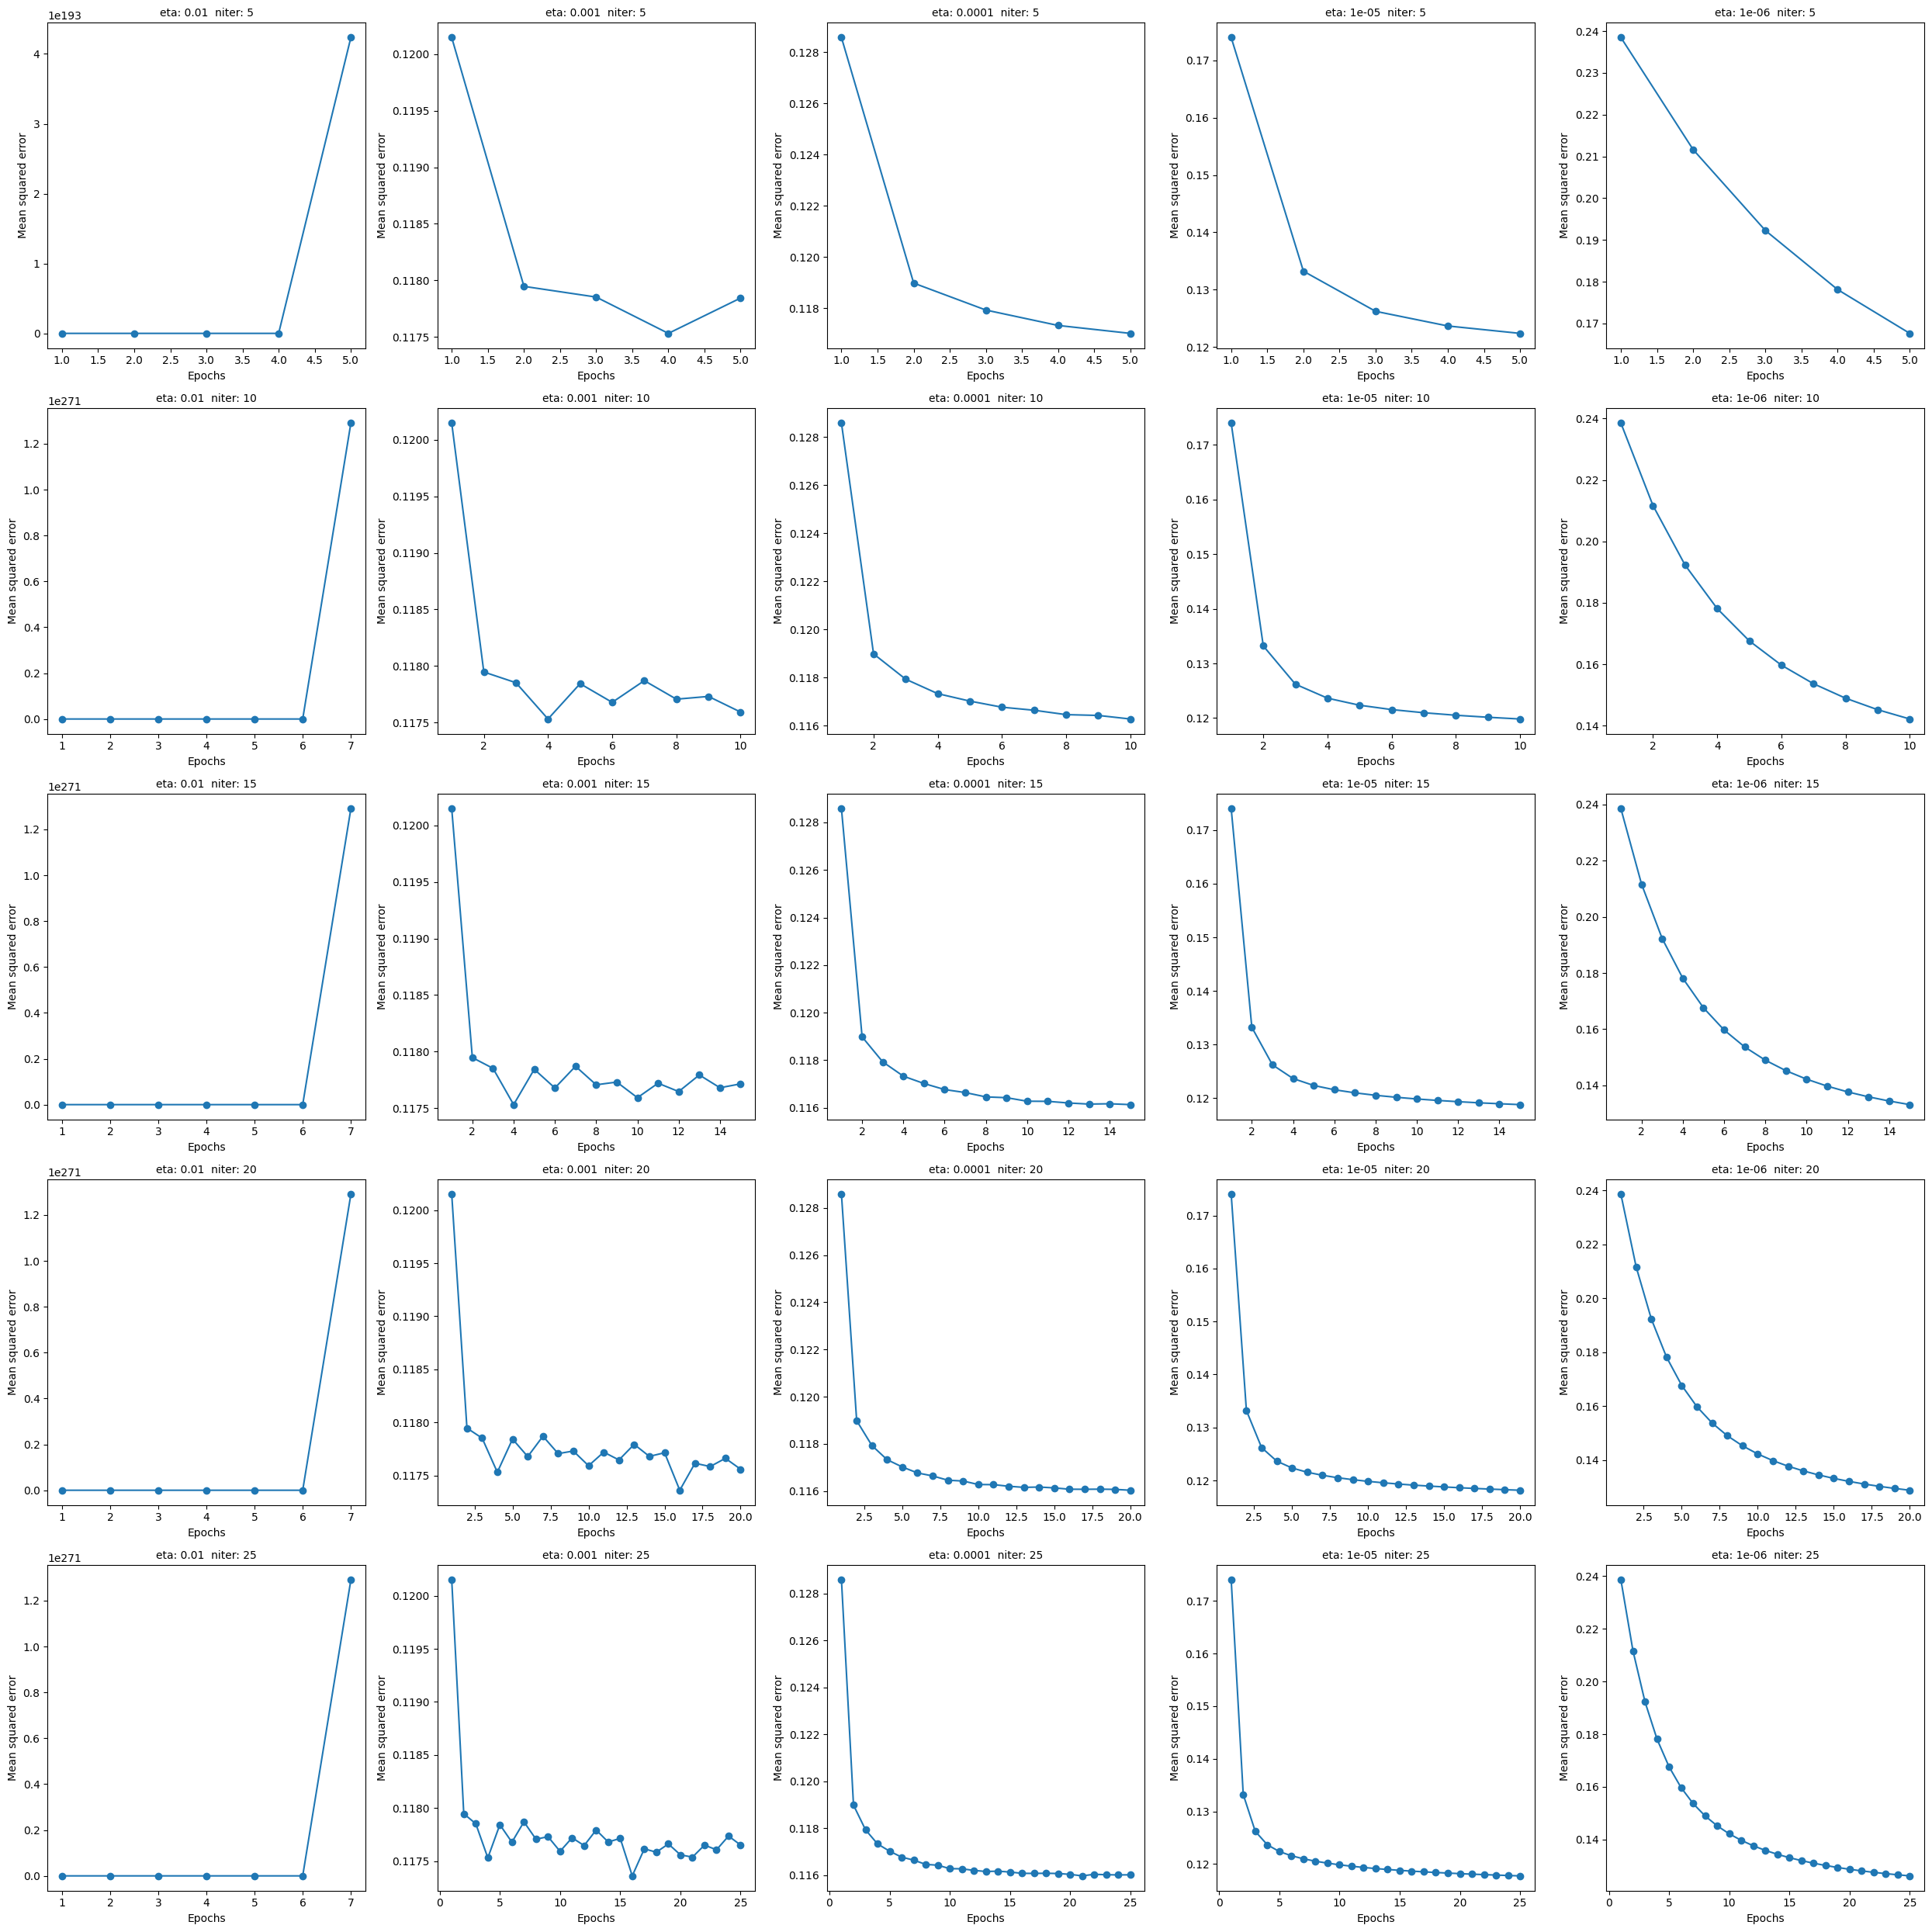


Highest accuracy: 0.8430 with eta 0.0001 and n_iter 10


In [76]:
# adaline sgd
# code pulled from in class activities

# initialize plot
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))

# tuned hyperparameters
list_eta = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
list_niter = [5, 10, 15, 20, 25]

# added this to assist in finding the best combo for highest accuracy
best_accuracy = 0
best_combo = (None, None)  # (eta, n_iter)

for j, n_temp in enumerate(list_niter):

    for i, e_temp in enumerate(list_eta):
        ada = AdalineSGD(n_iter=n_temp, eta=e_temp, shuffle=True, random_state=42).fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
        ax[j, i].plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Mean squared error', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)

        y_pred = ada.predict(X_test.loc[:,feature_cols].values)
        acc = accuracy_score(y_test.loc[:, 'class'].values, y_pred)        
        print(f"Adaline accuracy with n_iter {n_temp} and eta {e_temp}: {acc:.4f}")

        if acc > best_accuracy:        # update everytime there's a new highest accuracy
            best_accuracy = acc            
            best_combo = (e_temp, n_temp)
    
plt.tight_layout()
plt.show()

# print out highest accuracy combo
print(f"\nHighest accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and n_iter {best_combo[1]}")

In [77]:
# Sklearn perceptron
# Used the provided code and developed it into a loop to find the best values for the hyperparameters 

# tuned hyperparameters
list_eta = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
list_niter = [5, 10, 15, 20, 25]

# added this to assist in finding the best combo with the highest accuracy
best_accuracy = 0
best_combo = (None, None)  # (eta, max_iter)

for j, n_temp in enumerate(list_niter):
    for i, e_temp in enumerate(list_eta):
        sk_ppn = SklearnPerceptron(eta0=e_temp, max_iter=n_temp, random_state=42, tol=None)

        sk_ppn = sk_ppn.fit(X_train.loc[:, feature_cols].values, y_train.loc[:, 'class'].values)

        sk_y_pred_ppn = sk_ppn.predict(X_test.loc[:, feature_cols].values)
        acc = accuracy_score(y_test.loc[:, 'class'].values, sk_y_pred_ppn)
        print(f"Scikit-learn Perceptron accuracy with max_iter {n_temp} and eta {e_temp}: {acc:.4f}")

        if acc > best_accuracy:     # update each time a new highest accuracy is found
            best_accuracy = acc
            best_combo = (e_temp, n_temp)
 
# print out best params for highest accuracy
print(f"\nHighest accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and max_iter {best_combo[1]}")


Scikit-learn Perceptron accuracy with max_iter 5 and eta 0.01: 0.8225
Scikit-learn Perceptron accuracy with max_iter 5 and eta 0.001: 0.8225
Scikit-learn Perceptron accuracy with max_iter 5 and eta 0.0001: 0.8225
Scikit-learn Perceptron accuracy with max_iter 5 and eta 1e-05: 0.8225
Scikit-learn Perceptron accuracy with max_iter 5 and eta 1e-06: 0.8225
Scikit-learn Perceptron accuracy with max_iter 10 and eta 0.01: 0.8079
Scikit-learn Perceptron accuracy with max_iter 10 and eta 0.001: 0.8079
Scikit-learn Perceptron accuracy with max_iter 10 and eta 0.0001: 0.8079
Scikit-learn Perceptron accuracy with max_iter 10 and eta 1e-05: 0.8079
Scikit-learn Perceptron accuracy with max_iter 10 and eta 1e-06: 0.8079
Scikit-learn Perceptron accuracy with max_iter 15 and eta 0.01: 0.8200
Scikit-learn Perceptron accuracy with max_iter 15 and eta 0.001: 0.8200
Scikit-learn Perceptron accuracy with max_iter 15 and eta 0.0001: 0.8200
Scikit-learn Perceptron accuracy with max_iter 15 and eta 1e-05: 0.82

In [78]:
# Sklearn perceptron loop using CV to see if it'll help us choose between versions of the model 
# because we're seeing multiple combos of params producing same accuracy

# same param options that was given in the above sklearn perceptron loop
list_eta = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
list_niter = [5, 10, 15, 20, 25]

# tracking best accuracy
best_accuracy = 0
best_combo = (None, None)  # (eta, max_iter)

for n_temp in list_niter:
    for e_temp in list_eta:
        sk_ppn = SklearnPerceptron(eta0=e_temp, max_iter=n_temp, random_state=42, tol=None)

        # using cross validation with cv = 5
        scores = cross_val_score(sk_ppn, X_train.loc[:, feature_cols].values, y_train.loc[:, 'class'].values, cv=5)
        mean_acc = scores.mean() # looking for mean accuracy across folds

        print(f"CV mean accuracy with max_iter {n_temp} and eta {e_temp}: {mean_acc:.4f}")

        if mean_acc > best_accuracy:    # update each time new highest accuracy is found
            best_accuracy = mean_acc
            best_combo = (e_temp, n_temp)

print(f"\nBest CV mean accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and max_iter {best_combo[1]}")

CV mean accuracy with max_iter 5 and eta 0.01: 0.8089
CV mean accuracy with max_iter 5 and eta 0.001: 0.8089
CV mean accuracy with max_iter 5 and eta 0.0001: 0.8089
CV mean accuracy with max_iter 5 and eta 1e-05: 0.8089
CV mean accuracy with max_iter 5 and eta 1e-06: 0.8089
CV mean accuracy with max_iter 10 and eta 0.01: 0.8154
CV mean accuracy with max_iter 10 and eta 0.001: 0.8154
CV mean accuracy with max_iter 10 and eta 0.0001: 0.8154
CV mean accuracy with max_iter 10 and eta 1e-05: 0.8154
CV mean accuracy with max_iter 10 and eta 1e-06: 0.8154
CV mean accuracy with max_iter 15 and eta 0.01: 0.8125
CV mean accuracy with max_iter 15 and eta 0.001: 0.8125
CV mean accuracy with max_iter 15 and eta 0.0001: 0.8125
CV mean accuracy with max_iter 15 and eta 1e-05: 0.8125
CV mean accuracy with max_iter 15 and eta 1e-06: 0.8125
CV mean accuracy with max_iter 20 and eta 0.01: 0.7872
CV mean accuracy with max_iter 20 and eta 0.001: 0.7872
CV mean accuracy with max_iter 20 and eta 0.0001: 0.78

In [79]:
# Sklearn adaline loop 

# tuned hyperparameters
list_eta = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
list_niter = [5, 10, 12, 15, 18, 20]

# track highest accuracy
best_accuracy = 0
best_combo = (None, None)  # (eta, max_iter)

for j, n_temp in enumerate(list_niter):
    for i, e_temp in enumerate(list_eta):
        sk_ada = SGDClassifier(loss='perceptron', eta0=e_temp, learning_rate='constant', max_iter=n_temp, random_state=42, tol = None)

        sk_ada = sk_ada.fit(X_train.loc[:, feature_cols].values, y_train.loc[:, 'class'].values)

        sk_y_pred_ada = sk_ada.predict(X_test.loc[:, feature_cols].values)
        acc = accuracy_score(y_test.loc[:, 'class'].values, sk_y_pred_ada)
        print(f"Scikit-learn Adaline accuracy with max_iter {n_temp} and eta {e_temp}: {acc:.4f}")

        if acc > best_accuracy:     # update each time new highest accuracy is found
            best_accuracy = acc
            best_combo = (e_temp, n_temp)
 
# print out combo that had highest accuracy
print(f"\nHighest accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and max_iter {best_combo[1]}")

Scikit-learn Adaline accuracy with max_iter 5 and eta 0.01: 0.8194
Scikit-learn Adaline accuracy with max_iter 5 and eta 0.001: 0.7931
Scikit-learn Adaline accuracy with max_iter 5 and eta 0.0001: 0.8230
Scikit-learn Adaline accuracy with max_iter 5 and eta 1e-05: 0.8225
Scikit-learn Adaline accuracy with max_iter 5 and eta 1e-06: 0.8225
Scikit-learn Adaline accuracy with max_iter 10 and eta 0.01: 0.7808
Scikit-learn Adaline accuracy with max_iter 10 and eta 0.001: 0.8250
Scikit-learn Adaline accuracy with max_iter 10 and eta 0.0001: 0.8182
Scikit-learn Adaline accuracy with max_iter 10 and eta 1e-05: 0.8079
Scikit-learn Adaline accuracy with max_iter 10 and eta 1e-06: 0.8079
Scikit-learn Adaline accuracy with max_iter 12 and eta 0.01: 0.8090
Scikit-learn Adaline accuracy with max_iter 12 and eta 0.001: 0.8132
Scikit-learn Adaline accuracy with max_iter 12 and eta 0.0001: 0.8088
Scikit-learn Adaline accuracy with max_iter 12 and eta 1e-05: 0.7852
Scikit-learn Adaline accuracy with max_

In [80]:
# Sklearn adaline loop using CV just to see what happens since we did it for sklearn perceptron 

# same param options as given in about sklearn adaline loop
list_eta = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
list_niter = [5, 10, 15, 20, 25]

# track highest accuracy
best_accuracy = 0
best_combo = (None, None)  # (eta, max_iter)


for n_temp in list_niter:
    for e_temp in list_eta:
        sk_ada = SGDClassifier(loss = 'perceptron', eta0=e_temp, max_iter=n_temp, random_state=42, learning_rate='constant', tol = None)

        # use cross validation with cv = 5
        scores = cross_val_score(sk_ada, X_train.loc[:, feature_cols].values, y_train.loc[:, 'class'].values, cv=5)
        mean_acc = scores.mean() # mean acuracy across folds


        print(f"CV mean accuracy with max_iter {n_temp} and eta {e_temp}: {mean_acc:.4f}")

        if mean_acc > best_accuracy:    # update each time new highest accuracy is found
            best_accuracy = mean_acc
            best_combo = (e_temp, n_temp)

# print out best combo of params for highest accuracy
print(f"\nBest CV mean accuracy: {best_accuracy:.4f} with eta {best_combo[0]} and max_iter {best_combo[1]}")

CV mean accuracy with max_iter 5 and eta 0.01: 0.8033
CV mean accuracy with max_iter 5 and eta 0.001: 0.8015
CV mean accuracy with max_iter 5 and eta 0.0001: 0.8128
CV mean accuracy with max_iter 5 and eta 1e-05: 0.8147
CV mean accuracy with max_iter 5 and eta 1e-06: 0.8130
CV mean accuracy with max_iter 10 and eta 0.01: 0.8196
CV mean accuracy with max_iter 10 and eta 0.001: 0.8124
CV mean accuracy with max_iter 10 and eta 0.0001: 0.8143
CV mean accuracy with max_iter 10 and eta 1e-05: 0.8156
CV mean accuracy with max_iter 10 and eta 1e-06: 0.8140
CV mean accuracy with max_iter 15 and eta 0.01: 0.8107
CV mean accuracy with max_iter 15 and eta 0.001: 0.8126
CV mean accuracy with max_iter 15 and eta 0.0001: 0.8084
CV mean accuracy with max_iter 15 and eta 1e-05: 0.8162
CV mean accuracy with max_iter 15 and eta 1e-06: 0.8062
CV mean accuracy with max_iter 20 and eta 0.01: 0.7579
CV mean accuracy with max_iter 20 and eta 0.001: 0.7824
CV mean accuracy with max_iter 20 and eta 0.0001: 0.78

In [ ]:
# Implement best verson of Perceptron on validation dataset

# manual perceptron had accuracy =  0.8207 with eta 0.001 and n_iter 25
# sklearn perceptron had accuracy = 0.8280 with eta 0.01 and max_iter 20
# using sklearn version for predictions due to better accuracy and reliability

ppn_best = SklearnPerceptron(max_iter=20, eta0=0.01, random_state=42, tol = None).fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
y_pred_best_ppn = ppn_best.predict(X_df_test.loc[:,feature_cols].values)


df_ppn_pred = pd.DataFrame({
    'original_index': X_df_test['original_index'].values,
    'ppn_pred': y_pred_best_ppn
})


display(df_ppn_pred.head())

#df_ppn_pred.to_csv('../results/Group_2_Perceptron_PredictedOutputs.csv', index=False)

,original_index,ppn_pred
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
# Implement best verson of Adaline SGD on validation dataset (Sklearn version)

# manual adaline had accuracy = 0.8430 with eta 0.0001 and n_iter 10
# sklearn adaline had accuracy = 0.8355 with eta 1e-05 and max_iter 20
# sklearn appeared to underperform compared to manual but still using it for predictions 
    # since we were able to verify consistent accuracy with CV

ada_best = SGDClassifier(loss='perceptron', eta0=0.00001, learning_rate='constant', max_iter=20, random_state=42, tol = None).fit(X_train.loc[:,feature_cols].values, y_train.loc[:,'class'].values)
y_pred_best_ada = ada_best.predict(X_df_test.loc[:,feature_cols].values)


df_ada_pred = pd.DataFrame({
    'original_index': X_df_test['original_index'].values,
    'adaline_predictions': y_pred_best_ada
})


display(df_ada_pred.head())

#df_ada_pred.to_csv('../results/Group_2_Adaline_PredictedOutputs.csv', index=False)

,original_index,adaline_predictions
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
